In [1]:
import os
import random 

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
from keras.models import Sequential
from keras.layers import Input, merge
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


In [2]:
def pre(matrix):
    matrix1 = copy.deepcopy(matrix)
    for i in range(0,len(matrix1) - 1):
        matrix1[i].append(matrix1[i+1][0])
        #matrix1[i].append(matrix1[i+1][1])
    matrix1[len(matrix1) - 1].append(0)
    #matrix1[len(matrix1) - 1].append(1)
    return matrix1

time = 0
train = []
while(time < 50):
    init = [0.5, 0, 0, 0.5, 0, 0.6, 0, 0.7, 0, 0.71, 0, 0.72]
    matrix=[]
    for i in range(1,11): 
        a = copy.deepcopy(init)
        matrix.append(a)
        if i >= 5:
            init[0] = init[0] - 0.1 + i * np.random.uniform(0, 0.015)
        else:
            init[0] = init[0]+ np.random.uniform(-0.05, 0.05)
        init[1]=init[1]+0.1+np.random.uniform(-0.02, 0.03)
        init[2]=init[2]+0.1+np.random.uniform(-0.02, 0.03)
        init[3]+=np.random.uniform(-0.01, 0.02)
        init[4]=init[4]+0.1+np.random.uniform(-0.02, 0.03)
        init[5]+=np.random.uniform(-0.01, 0.03)
        init[6]=init[6]+0.1+np.random.uniform(-0.02, 0.03)
        init[7]+=np.random.uniform(-0.01, 0.04)
        init[8]=init[8]+0.1+np.random.uniform(-0.02, 0.03)
        init[9]+=np.random.uniform(-0.01, 0.05)
        init[10]=init[10]+0.1+np.random.uniform(-0.02, 0.03)
        init[11]+=np.random.uniform(-0.01, 0.05)
    matrix = pre(matrix)
    b = copy.deepcopy(matrix)
    b = np.array(b)
    train.append(b)
    time += 1

train = np.array(train)
np.array(train[0]).shape
X_train = []
for i in train:
    for j in i:
        X_train.append(j)
X_train = np.array(X_train)

In [3]:
def generative_adversarial_network(generator_model, discriminator_model):

    gan_model = Sequential()
    gan_model.add(generator_model)
    discriminator_model.trainable = False
    gan_model.add(discriminator_model)
    return gan_model


random.seed(123)
z_input_vector = 20

generator_optimizer = SGD(lr=0.1, momentum=0.3, decay=1e-5)
discriminator_optimizer = SGD(lr=0.1, momentum=0.1, decay=1e-5)
gan_optimizer = SGD(lr=0.1, momentum=0.3)

generator = Sequential()
generator.add(Dense(input_dim=20, output_dim=160, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(120, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(100, init='glorot_uniform'))
generator.add(BatchNormalization(mode=0))
generator.add(LeakyReLU(alpha=0.3))
generator.add(Dense(12, init='glorot_uniform', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
#generator.summary()

# Discriminator Model
discriminator = Sequential()
discriminator.add(Dense(input_dim=12, output_dim=240, init='glorot_uniform'))
discriminator.add(LeakyReLU(alpha=0.3))
discriminator.add(Dense(output_dim=240, init='glorot_uniform'))
discriminator.add(LeakyReLU(alpha=0.1))
discriminator.add(Dense(output_dim=240, init='glorot_uniform', activation='relu'))
discriminator.add(Dropout(0.2))
discriminator.add(Dense(1, init='glorot_uniform'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer,
                      metrics=['fbeta_score'])
#discriminator.summary()

# Build the gan framework
gan = generative_adversarial_network(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
#gan.summary()

In [4]:
#X_train = np.random.uniform(0, 1, size=[n_train_samples, 14])
X_train = X_train.astype('float32')
X_real = X_train[:,0:12]
noise_gen = np.random.uniform(0, 1, size=[len(X_real), 20])

initial_generated_images = generator.predict_on_batch(noise_gen)


In [5]:
X = np.concatenate((X_real, initial_generated_images))

n = X_real.shape[0]
y = np.zeros(int(2*n))
y[n:] = 1
y = y.astype(int)
discriminator.trainable = True
discriminator.fit(X, y, nb_epoch=1, batch_size=300)

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.6856 - fbeta_score: 0.3938     


In [6]:
# Determine the accuracy of the model
y_hat = discriminator.predict_on_batch(X)
accuracy = (2*n - np.sum(np.abs(y - y_hat.round().transpose()))) / (2*n)
print('Accuracy = {}'.format(accuracy))

Accuracy = 0.5


In [7]:
def train_for_n(z_input, generator_model, discriminator_model, gan_model, X_train):
    epoch = 500
    batch=10
    with tqdm(total=epoch) as pbar:
        for e in range(epoch):
            
            pbar.update(1)

            # Make random generative images   
            noise = np.random.uniform(0, 1, size=[batch, z_input])
            generated_images = generator_model.predict_on_batch(noise)
            

                

            # Subset random batch of training data
            rand_train_index = np.random.randint(0, X_train.shape[0], size=batch)
            image_batch = X_train[rand_train_index, :] 

            # Combine generated images with training data
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros(int(2*batch))
            y[batch:] = 1  # Fake images get 1, real images get 0
            y = y.astype(int)

            # Train the discriminator to correctly detect fake images from real
            discriminator.trainable = True
            d_loss, d_f_score = discriminator_model.train_on_batch(x=X, y=y)
            discriminator.trainable = False

            # Coerce generator to try to make real samples
            noise = np.random.uniform(0, 1, size=[batch, z_input])
            y = np.zeros(batch)
            y = y.astype(int)
            g_loss = gan_model.train_on_batch(x=noise, y=y)

    
    return generated_images



In [8]:

xxx = train_for_n(z_input=z_input_vector, generator_model=generator,
            discriminator_model=discriminator, gan_model=gan, X_train = X_real)

100%|██████████| 500/500 [00:08<00:00, 58.48it/s]


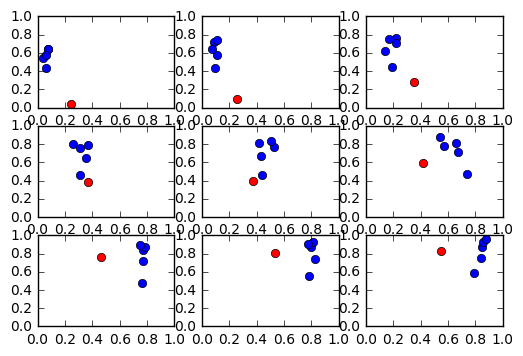

In [9]:
import matplotlib.pyplot as plt
xxx = np.array(xxx)
gg = np.sort(xxx, axis=0)
for i in range(0, 9):
    temp = gg[i]
    plt.subplot(3, 3, i+1)
    plt.plot(temp[0],temp[1],'ro')
    plt.plot(temp[2],temp[3],'bo')
    plt.plot(temp[4],temp[5],'bo')
    plt.plot(temp[6],temp[7],'bo')
    plt.plot(temp[8],temp[9],'bo')
    plt.plot(temp[10],temp[11],'bo')
    plt.axis([0,1,0,1])
plt.show()


